In [1]:
import folium
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import branca.colormap as cm
from matplotlib.colors import ListedColormap
class FoliumMap:
    """create folium map object"""
    def __init__(
        self,
        da_data_map: xr.DataArray,
        var_input: str,
        n_inc: int,
        vmin: float,
        vmax: float,
        cbar_name: str
    ):
        """define needed info when creating the folium map

        Parameters
        ----------
        da_data : xr.Dataset
            the map slice contained in a dataarray
        var_input : str
            variable name used in the dataarray
        n_inc : int
            number of increments used for the colorbar
        vmin : float
            minimum value shows on the colorbar
        vmax : float
            maximum value shows on the colorbar
        cbar_name : str
            the colorbar name in the matplotlib library
        """
        self.da_data = da_data_map
        self.var = var_input
        self.n_increments = n_inc
        self.varmin = vmin
        self.varmax = vmax
        self.cbar = cbar_name
        self.varname = None    # dynamically defined later
        self.tick_inc = None   # dynamically defined later

    def define_fig_setting(self):
        """Setting the Folium related legend info"""
        # figure setting
        self.varname = self.da_data.attrs['long_name']

        # mix layer longname contain () causing the parsing in javascript of regular
        #  expression to fail. Current solution is to replace ()
        if "(" in self.varname:
            self.varname = self.varname.replace('(', '- ')
        if ")" in self.varname:
            self.varname = self.varname.replace(')', '')

        if self.n_increments is None:
            self.n_increments = 20
        else:
            self.n_increments = int(self.n_increments)

        if self.varmin is None:
            self.varmin = self.da_data.min().data
            if 'prob' in self.var :
                self.varmin = 0
        else:
            self.varmin = float(self.varmin)

        if self.varmax is None:
            self.varmax = self.da_data.max().data
            if 'prob' in self.var :
                self.varmax = 100
        else:
            self.varmax = float(self.varmax)

        if self.varmax < self.varmin:
            print('exit')
        elif self.varmax == self.varmin:
            if self.var in ['siconc'] :
                # if all are zeros the figures cannot
                # show blue correctly. need to have at
                # least one point that is 0.5
                # current force lower right corner (tropic) to be 0.5
                self.varmin = 0
                self.varmax = 1
                self.da_data[0,-1] += 0.5
            else:
                print('exit')

        if self.n_increments<0 :
            print('exit')

        self.tick_inc = np.abs(self.varmax-self.varmin)/10.

    def create_folium(self):
        """create the folium map and the branca colormap"""
        # define dynamic attributes
        self.define_fig_setting()

        if self.cbar == 'twosidecut':
            num_away = int(self.n_increments*0.25)
            picked_cm = plt.get_cmap(self.cbar, self.n_increments+2*num_away)
            start_fraction = num_away/(self.n_increments+2*num_away)
            end_fraction = (self.n_increments+num_away)/(self.n_increments+2*num_away)
            new_colors = picked_cm(np.linspace(start_fraction,end_fraction,self.n_increments))
            # Create a new colormap using the sliced colors
            picked_cm = ListedColormap(new_colors)
        elif self.cbar == 'inferno':
            num_away = int(self.n_increments*0.15)
            picked_cm = plt.get_cmap(self.cbar, self.n_increments+num_away)
            start_fraction = 0.
            end_fraction = (self.n_increments)/(self.n_increments+num_away)
            new_colors = picked_cm(np.linspace(start_fraction,end_fraction,self.n_increments))
            # Create a new colormap using the sliced colors
            picked_cm = ListedColormap(new_colors)
        else:
            # setup the colormap from matplotlib
            picked_cm = plt.get_cmap(self.cbar, self.n_increments)

        # normalized data (0,1) for colormap to applied on
        normed_data = (self.da_data - self.varmin) / (self.varmax - self.varmin)
        colored_data = picked_cm(normed_data.data)
        # index_list = range(0,self.n_increments)
        cmap_list = picked_cm(range(self.n_increments)).tolist()

        # folium map base map
        fm = folium.Map(
            location=[
                float(self.da_data.lat.mean().data),
                float(self.da_data.lon.mean().data)
            ],
            tiles="Cartodb Positron",
            zoom_start=3
        )

        # overlay the raster image (colored data) on the map
        #  !!!! the data need to be in linspace dimension !!!! (regridded needed)
        #  !!!! for the correct projection                !!!!
        folium.raster_layers.ImageOverlay(
            image=colored_data,
            bounds=[[float(self.da_data.lat.min().data),
                    float(self.da_data.lon.min().data)],
                    [float(self.da_data.lat.max().data),
                    float(self.da_data.lon.max().data)]],
            mercator_project=True,   # applied data to web mercator projection (essential)
            origin="lower",          # plot data from lower bound (essential)
            # pixelated=False,
            opacity=1,
            zindex=1
        ).add_to(fm)

        # start constructing the branca colormap to put on folium map
        if self.tick_inc<1e-4:
            label_list = np.arange(self.varmin,self.varmax+self.tick_inc*1e-5,self.tick_inc)
            order_of_m = int(np.log10(abs(self.tick_inc)))
            label_list = [label*10**np.abs(order_of_m) for label in label_list]
            branca_tick_label = list(label_list)
        else:
            order_of_m = None
            label_list = np.arange(self.varmin,self.varmax+self.tick_inc*1e-5,self.tick_inc)
            branca_tick_label = list(label_list)

        cmap_foliump = cm.LinearColormap(
            colors=cmap_list,
            vmin=branca_tick_label[0],
            vmax=branca_tick_label[-1],
            caption='fcmap',
            max_labels=self.n_increments+1,
            tick_labels=branca_tick_label
        ).to_step(self.n_increments)

        # Add the colormap to the folium map
        if order_of_m is None :
            var_unit = f"{self.da_data.attrs['units']}"
        else:
            var_unit = f"x{10**order_of_m:1.0E} {self.da_data.attrs['units']}"

        cmap_foliump.caption = f"{self.varname} / {var_unit}"
        if len(cmap_foliump.caption)>50:
            cmap_foliump.caption = f"{self.var} / {var_unit}"

        cmap_foliump.add_to(fm)

        return fm

    


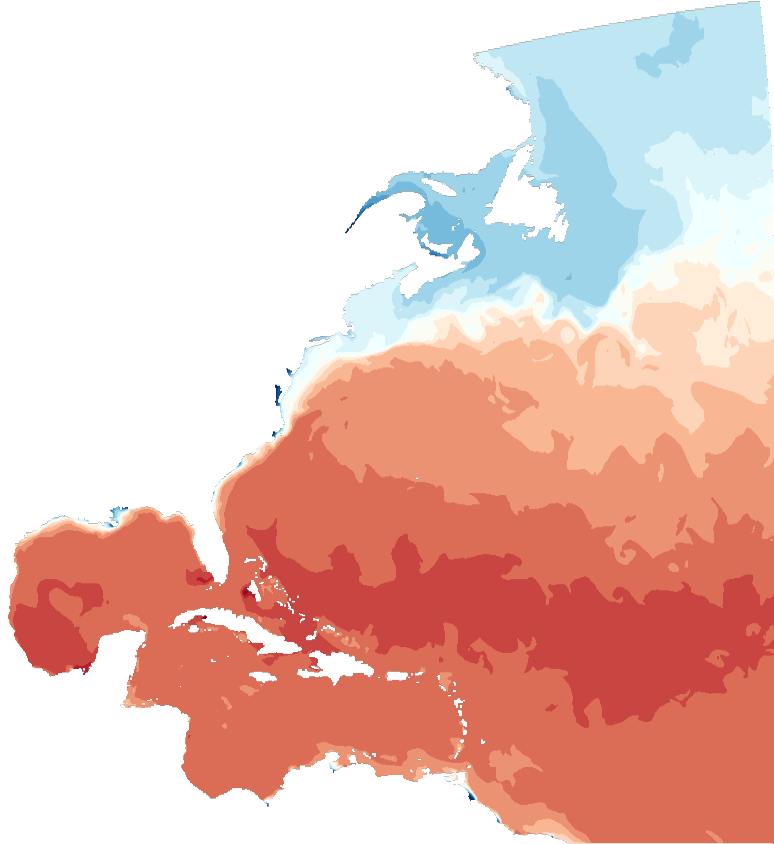

In [12]:
ds_regrid = xr.open_dataset('sfc_co3_ion_test.nc')
# creating the folium map object
cbar = 'RdBu_r'
n_increments = 20
varmin = None
varmax = None
var = 'sfc_co3_ion'
da_data = ds_regrid[var]
ClassFoliumMap = FoliumMap(da_data,var,n_increments,varmin,varmax,cbar)
folium_map = ClassFoliumMap.create_folium()
folium_map


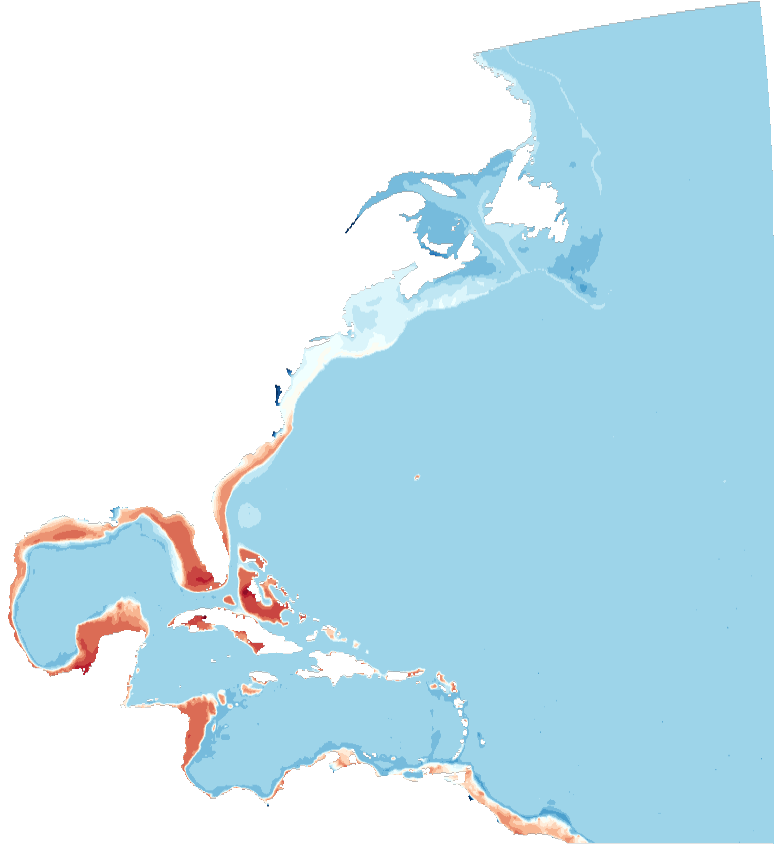

In [20]:
ds_regrid = xr.open_dataset('/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/regrid/r20230520/btm_co3_ion.nwa.full.hcast.monthly.regrid.r20230520.199301-201912.nc').isel(time=0).load()
# creating the folium map object
cbar = 'RdBu_r'
n_increments = 20
varmin = None
varmax = None
var = 'btm_co3_ion'
da_data = ds_regrid[var]
ClassFoliumMap = FoliumMap(da_data,var,n_increments,varmin,varmax,cbar)
folium_map = ClassFoliumMap.create_folium()
folium_map


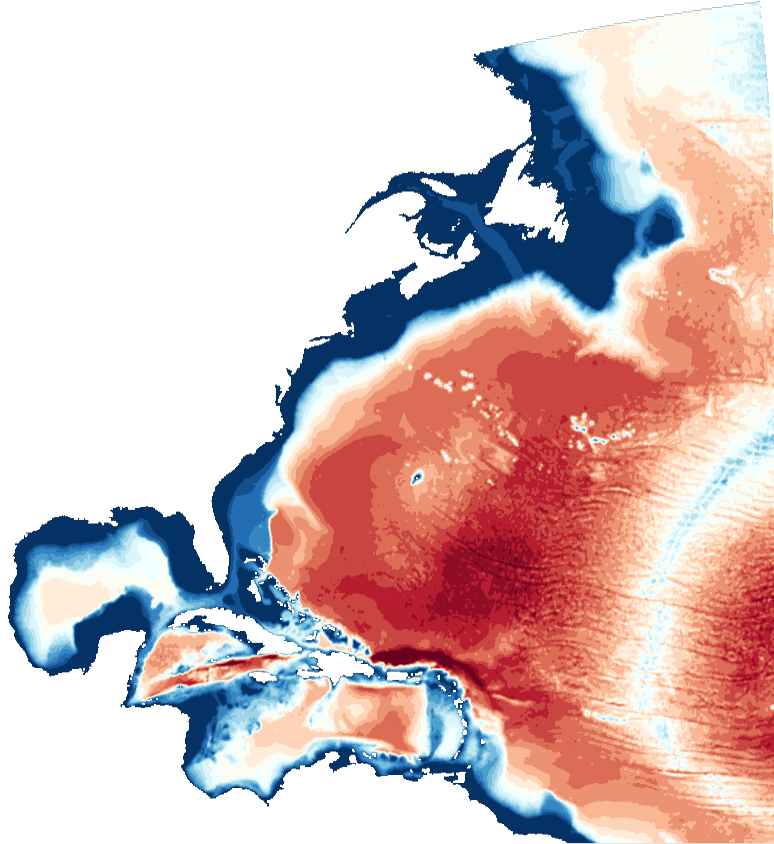

In [16]:
ds_static = xr.open_dataset('/Projects/CEFI/regional_mom6/cefi_derivative/northwest_atlantic/full_domain/hindcast/monthly/regrid/r20230520/static/ocean_static.deptho.nc').load()
# creating the folium map object
cbar = 'RdBu_r'
n_increments = 20
varmin = None
varmax = None
var = 'deptho'
da_data = ds_static[var]
ClassFoliumMap = FoliumMap(da_data,var,n_increments,varmin,varmax,cbar)
folium_map = ClassFoliumMap.create_folium()
folium_map

In [ ]:
ds_static['lon'] = ds_regrid.lon.data+360.
ds_regrid.lon.data+360.-ds_static.lon.data

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.68434189e-14,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.68434189e-14, -5.68434189e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.68434189e-14, -5.68434189e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.68434189e-14,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  


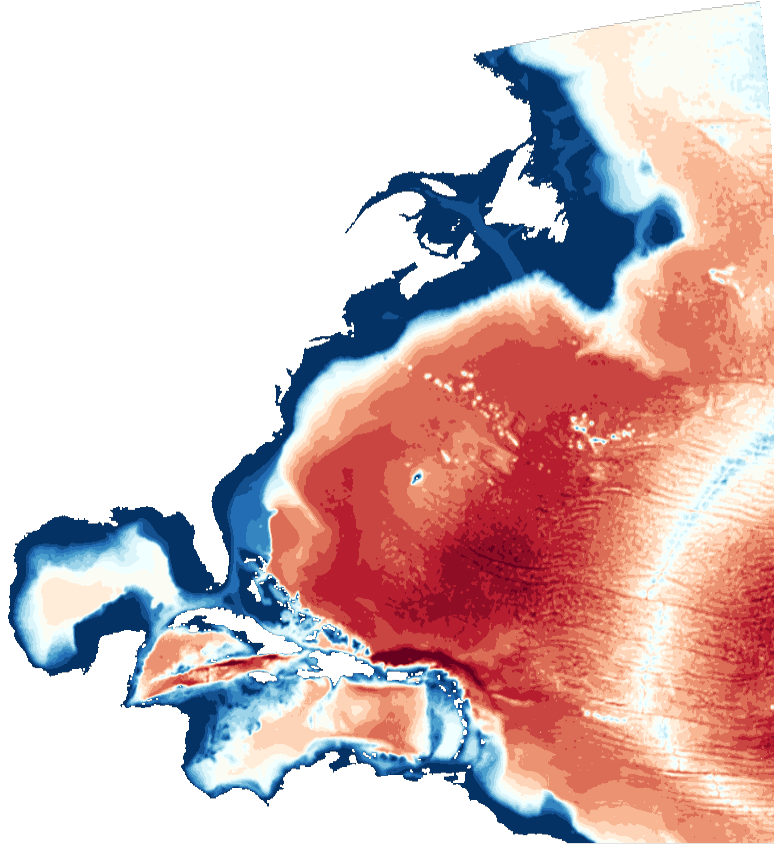

In [35]:
ds_regrid_lon = ds_regrid.copy(deep=True)
ds_static_lon = ds_static.copy(deep=True)
ds_regrid_lon['lon'] = ds_regrid['lon']+360.
ds_static_lon['lon'] = ds_regrid_lon['lon']
ds_regrid_lon['btm_co3_ion'] = ds_regrid_lon['btm_co3_ion']*ds_static_lon['deptho']
# creating the folium map object
cbar = 'RdBu_r'
n_increments = 20
varmin = None
varmax = None
var = 'btm_co3_ion'
da_data = ds_regrid_lon[var]
da_data.attrs['long_name'] = 'Bottom CO3 Ion Concentration'
da_data.attrs['units'] = 'mmol/m3'
ClassFoliumMap = FoliumMap(da_data,var,n_increments,varmin,varmax,cbar)
folium_map = ClassFoliumMap.create_folium()
folium_map

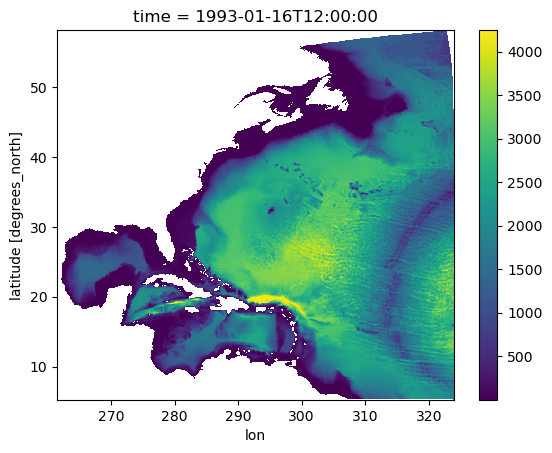

In [40]:
(ds_regrid_lon['btm_co3_ion']*ds_static['deptho']).plot()